In [54]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [48]:
plt.style.use('seaborn-v0_8')
sns.set_theme()

raw_path = "/content/Daily_Public_Transport_Passenger_Journeys_by_Service_Type_20250603.csv"
df = pd.read_csv(raw_path, encoding="utf-8-sig")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1918 entries, 0 to 1917
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          1918 non-null   object 
 1   Local Route   1918 non-null   int64  
 2   Light Rail    1918 non-null   int64  
 3   Peak Service  1918 non-null   int64  
 4   Rapid Route   1918 non-null   int64  
 5   School        1918 non-null   int64  
 6   Other         1898 non-null   float64
dtypes: float64(1), int64(5), object(1)
memory usage: 105.0+ KB


In [41]:
report = []   # to store documentation notes

report.append("DATA CLEANING REPORT\n")
report.append("---------------------\n")
report.append(f"Original file loaded: {raw_path}\n")
report.append(f"Initial shape: {df.shape}\n\n")
print(df.columns.tolist())

['Date', 'Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School', 'Other']


In [42]:
invalid_dates = df['Date'].isna().sum()
df['Date'] = pd.to_datetime(df['Date'], format="%d/%m/%Y", errors='coerce')

report.append(f"Converted Date column to datetime.\n")
report.append(f"Invalid date entries converted to NaT: {invalid_dates}\n\n")

df = df.dropna(subset=['Date'])
df = df.sort_values('Date').reset_index(drop=True)


In [43]:
before = len(df)
df = df.drop_duplicates()
after = len(df)

report.append(f"Duplicates removed: {before - after}\n\n")


In [44]:
missing_before = df.isnull().sum()

report.append("Missing values before cleaning:\n")
report.append(str(missing_before) + "\n\n")

numeric_cols = ['Local Route', 'Light Rail', 'Peak Service',
                'Rapid Route', 'School', 'Other']

df = df.set_index('Date')
df[numeric_cols] = df[numeric_cols].interpolate(method='time')
df[numeric_cols] = df[numeric_cols].fillna(method='ffill').fillna(method='bfill')
df = df.reset_index()

missing_after = df.isnull().sum()
report.append("Missing values after cleaning:\n")
report.append(str(missing_after) + "\n\n")

/tmp/ipython-input-2079270687.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[numeric_cols] = df[numeric_cols].fillna(method='ffill').fillna(method='bfill')


In [45]:
negatives_info = {}

for col in numeric_cols:
    neg_values = (df[col] < 0).sum()
    negatives_info[col] = neg_values
    df[col] = df[col].clip(lower=0)

report.append("Negative values found (fixed using clip lower=0):\n")
report.append(str(negatives_info) + "\n\n")


In [46]:
output_dir = "/mnt/data/cleaned_data"
os.makedirs(output_dir, exist_ok=True)

cleaned_path = f"{output_dir}/cleaned_transport_data.csv"
df.to_csv(cleaned_path, index=False)

report.append(f"Cleaned dataset saved at: {cleaned_path}\n\n")

In [47]:
report_path = f"{output_dir}/data_cleaning_report.txt"

with open(report_path, "w") as f:
    f.writelines(report)

print("Data cleaning completed.")
print(f"Cleaned CSV saved at: {cleaned_path}")
print(f"Documentation saved at: {report_path}")

Data cleaning completed.
Cleaned CSV saved at: /mnt/data/cleaned_data/cleaned_transport_data.csv
Documentation saved at: /mnt/data/cleaned_data/data_cleaning_report.txt


In [49]:
date_col = None
for col in df.columns:
    if str(col).lower().strip() in ["date", "day"]:
        date_col = col
        df[date_col] = pd.to_datetime(df[date_col])
        break

print("Detected date column:", date_col)
print(df.head())

Detected date column: Date
        Date  Local Route  Light Rail  Peak Service  Rapid Route  School  \
0 2024-08-30        16436       10705           225        19026    3925   
1 2023-09-15        15499       10671           267        18421    4519   
2 2021-12-28         1756        2352             0         3775       0   
3 2023-01-11        10536        8347           223        14072       0   
4 2021-09-11          820         612             0         1283       0   

   Other  
0   59.0  
1   61.0  
2   13.0  
3   48.0  
4   11.0  


/tmp/ipython-input-2392828916.py:5: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[date_col] = pd.to_datetime(df[date_col])


In [51]:
print("\n===== SUMMARY STATISTICS =====")
print(df.describe())


===== SUMMARY STATISTICS =====
                      Date   Local Route    Light Rail  Peak Service  \
count                 1918   1918.000000   1918.000000   1918.000000   
mean   2022-02-13 12:00:00   9891.395203   7195.446298    179.581335   
min    2019-07-01 00:00:00      1.000000      0.000000      0.000000   
25%    2020-10-22 06:00:00   3044.500000   4463.500000      0.000000   
50%    2022-02-13 12:00:00  11417.000000   7507.000000    193.000000   
75%    2023-06-07 18:00:00  15517.500000  10008.250000    313.750000   
max    2024-09-29 00:00:00  21070.000000  15154.000000   1029.000000   
std                    NaN   6120.715714   3345.616428    156.532738   

        Rapid Route       School        Other  
count   1918.000000  1918.000000  1898.000000  
mean   12597.213243  2352.694995    43.390411  
min        0.000000     0.000000     0.000000  
25%     6383.000000     0.000000    14.000000  
50%    13106.500000   567.500000    40.000000  
75%    17924.750000  4914.00000

In [56]:
date_col = None
for col in df.columns:
    if str(col).lower() == "date":
        date_col = col
        df[date_col] = pd.to_datetime(df[date_col])
        break

df = df.sort_values(date_col).reset_index(drop=True)
numeric_cols = df.select_dtypes(include=np.number).columns

In [78]:
print("\n===== SUMMARY =====")
print(df.describe())


===== SUMMARY =====
                                Date   Local Route    Light Rail  \
count                           1898   1898.000000   1898.000000   
mean   2022-02-16 03:16:30.094836736   9921.582719   7216.707587   
min              2019-07-08 00:00:00     21.000000    375.000000   
25%              2020-10-30 06:00:00   3054.250000   4481.000000   
50%              2022-02-16 12:00:00  11432.500000   7536.000000   
75%              2023-06-05 18:00:00  15509.000000  10008.250000   
max              2024-09-23 00:00:00  21070.000000  15154.000000   
std                              NaN   6099.992129   3324.006188   

       Peak Service   Rapid Route       School        Other    Total_Load  \
count   1898.000000   1898.000000  1898.000000  1898.000000   1898.000000   
mean     179.925711  12630.298736  2364.301370    43.390411  32356.206533   
min        0.000000     49.000000     0.000000     0.000000    644.000000   
25%        0.000000   6396.000000     0.000000    14.00000

Outlier Analysis


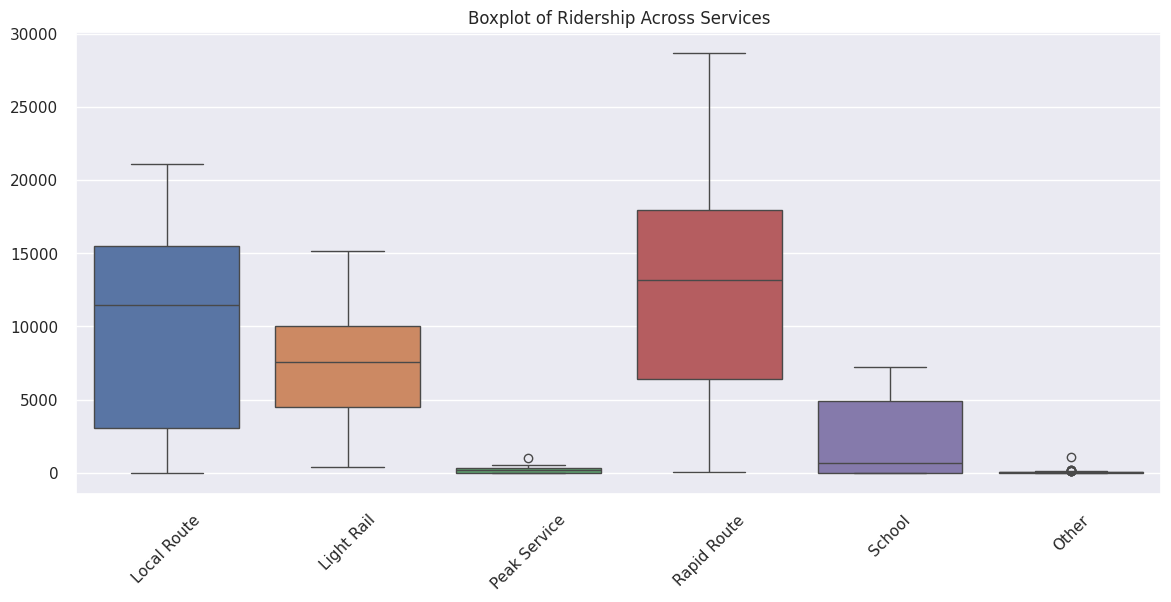

In [80]:
print("Outlier Analysis")
plt.figure(figsize=(14, 6))
sns.boxplot(data=df[numeric_cols])
plt.title("Boxplot of Ridership Across Services")
plt.xticks(rotation=45)
plt.show()

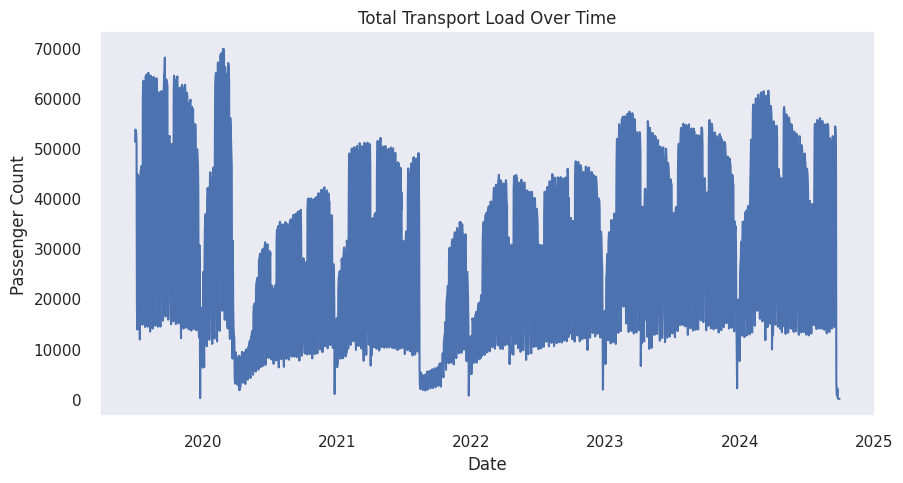

In [60]:
df["Total_Load"] = df[numeric_cols].sum(axis=1)

plt.figure(figsize=(10,5))
plt.plot(df[date_col], df["Total_Load"], label="Total Passenger Load")
plt.title("Total Transport Load Over Time")
plt.xlabel("Date")
plt.ylabel("Passenger Count")
plt.grid()plt.show()

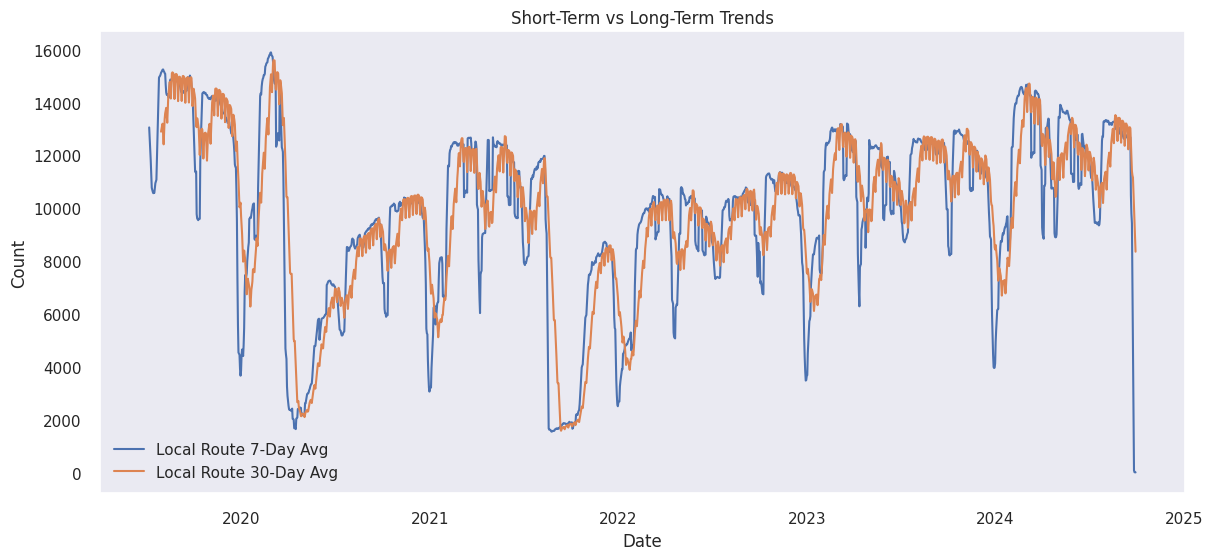

In [62]:
df_rolling = df.copy()
for col in numeric_cols:
    df_rolling[col+"_7d"] = df[col].rolling(7).mean()
    df_rolling[col+"_30d"] = df[col].rolling(30).mean()

plt.figure(figsize=(14,6))
plt.plot(df[date_col], df_rolling[numeric_cols[0]+"_7d"], label=numeric_cols[0]+" 7-Day Avg")
plt.plot(df[date_col], df_rolling[numeric_cols[0]+"_30d"], label=numeric_cols[0]+" 30-Day Avg")
plt.title("Short-Term vs Long-Term Trends")
plt.xlabel("Date")
plt.ylabel("Count")
plt.legend()
plt.grid()
plt.show()

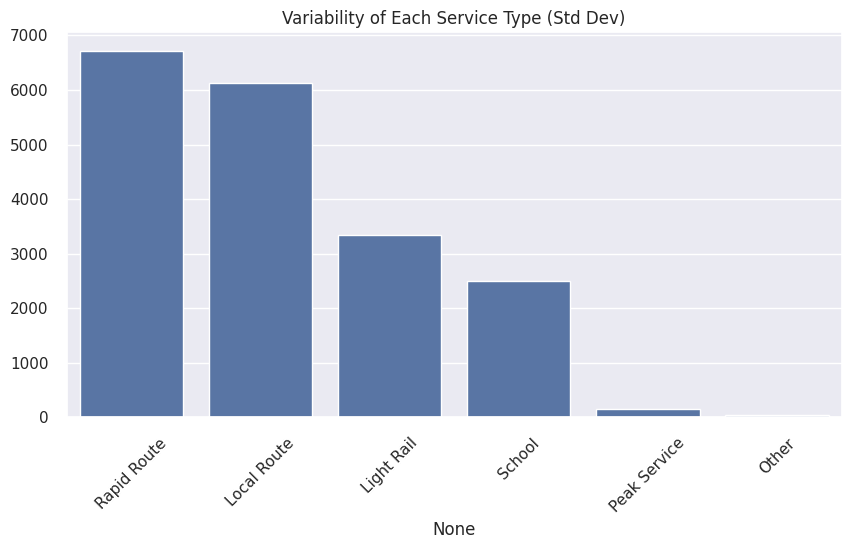


Most variable service: Rapid Route
Least variable service: Other


In [66]:
variability = df[numeric_cols].std().sort_values(ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x=variability.index, y=variability.values)
plt.title("Variability of Each Service Type (Std Dev)")
plt.xticks(rotation=45)
plt.show()

print("\nMost variable service:", variability.index[0])
print("Least variable service:", variability.index[-1])


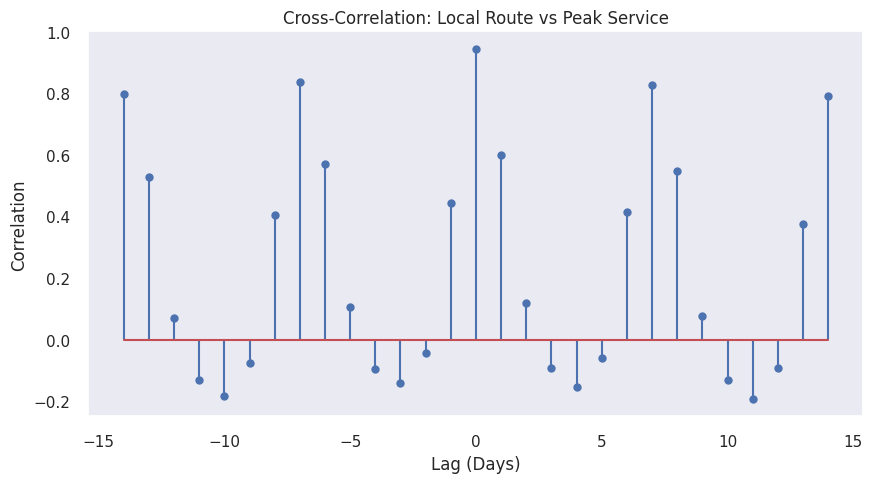

In [67]:
def cross_corr(a, b, max_lag=14):
    lags = range(-max_lag, max_lag+1)
    values = [a.corr(b.shift(lag)) for lag in lags]
    return lags, values

lags, corr_vals = cross_corr(df["Local Route"], df["Peak Service"])

plt.figure(figsize=(10,5))
plt.stem(lags, corr_vals)
plt.title("Cross-Correlation: Local Route vs Peak Service")
plt.xlabel("Lag (Days)")
plt.ylabel("Correlation")
plt.grid()
plt.show()

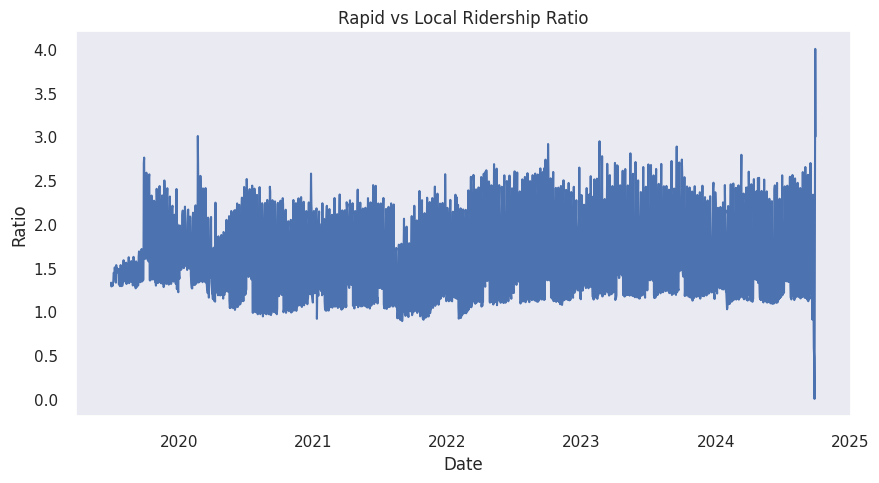

In [68]:
df["Rapid_vs_Local"] = df["Rapid Route"] / df["Local Route"]

plt.figure(figsize=(10,5))
plt.plot(df[date_col], df["Rapid_vs_Local"])
plt.title("Rapid vs Local Ridership Ratio")
plt.xlabel("Date")
plt.ylabel("Ratio")
plt.grid()
plt.show()

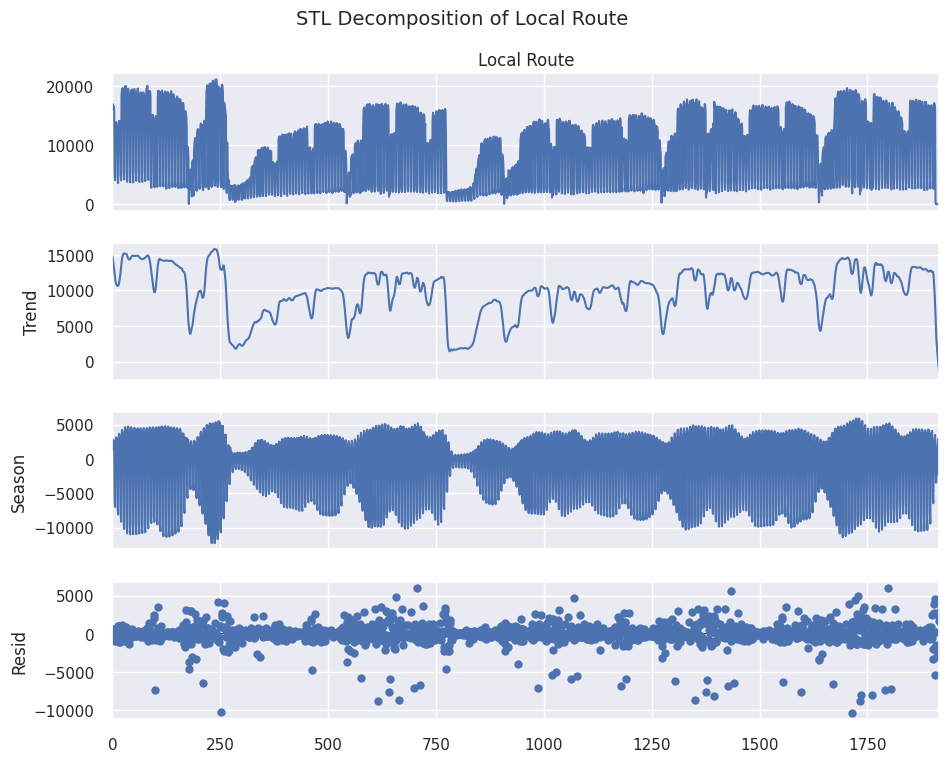

In [71]:
stl = STL(df[service_to_decompose], period=7)
result = stl.fit()

fig = result.plot()
fig.set_size_inches(10, 8)  # optional: larger figure

# Add spacing to avoid overlap
plt.subplots_adjust(top=0.90)

plt.suptitle(f"STL Decomposition of {service_to_decompose}", fontsize=14)
plt.show()


In [76]:
cluster_data = df[numeric_cols].copy()

cluster_data = cluster_data.dropna()

scaled = scaler.fit_transform(cluster_data)

df = df.loc[cluster_data.index]


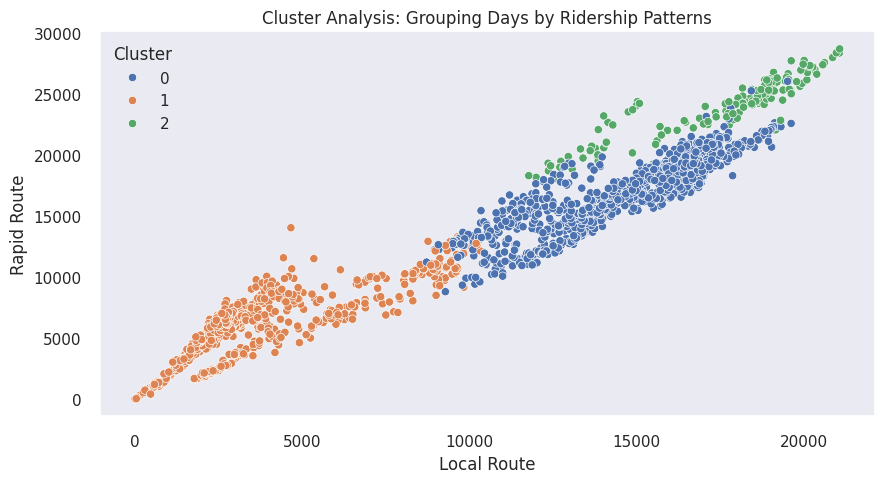

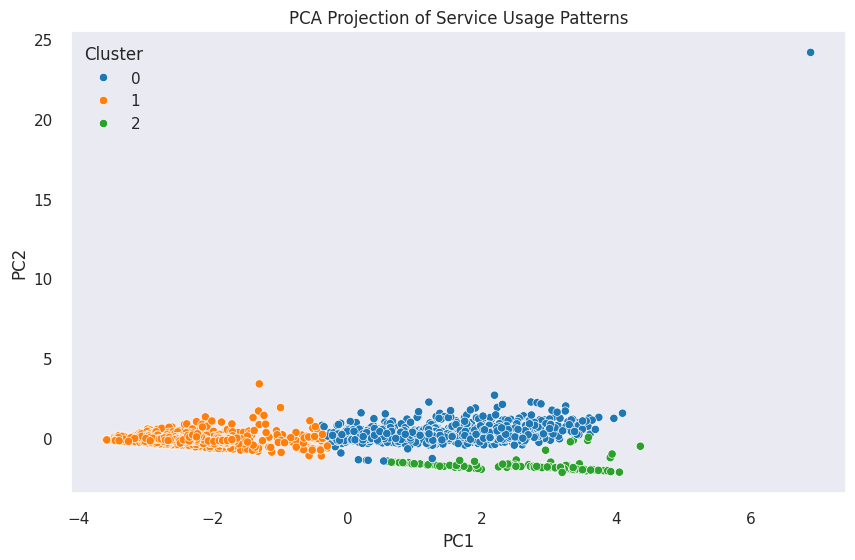


PCA Variance Explained:
[0.78413426 0.13016548]


In [77]:
cluster_data = df[numeric_cols]
scaler = StandardScaler()
scaled = scaler.fit_transform(cluster_data)

kmeans = KMeans(n_clusters=3, random_state=42)
df["Cluster"] = kmeans.fit_predict(scaled)

plt.figure(figsize=(10,5))
sns.scatterplot(x=df["Local Route"], y=df["Rapid Route"], hue=df["Cluster"], palette="deep")
plt.title("Cluster Analysis: Grouping Days by Ridership Patterns")
plt.grid()
plt.show()

pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled)

df["PC1"], df["PC2"] = pca_result[:,0], pca_result[:,1]

plt.figure(figsize=(10,6))
sns.scatterplot(x="PC1", y="PC2", hue="Cluster", data=df, palette="tab10")
plt.title("PCA Projection of Service Usage Patterns")
plt.grid()
plt.show()

print("\nPCA Variance Explained:")
print(pca.explained_variance_ratio_)